# Weapon Stats

## Setting Up

In [1]:
import pandas as pd

%run weapon_full_data.ipynb

## Damage

### Base Damage

How much damage a weapon can make in a single turn.

In [2]:
average_damage_mean = weapon_data[["weapon", "turn_damage_expected"]]
average_damage_mean = average_damage_mean.groupby("weapon").mean()

In [3]:
average_damage_max = weapon_data[["weapon", "turn_damage_max"]]
average_damage_max = average_damage_max.groupby("weapon").mean()

In [4]:
average_damage = average_damage_max.merge(average_damage_mean, on="weapon")
average_damage = average_damage.sort_values(by=["turn_damage_expected"])

Text(0, 0.5, 'Damage')

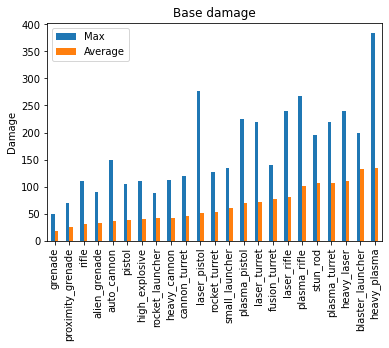

In [5]:
ax = average_damage.plot.bar(title="Base damage", legend=False)
ax.legend(["Max", "Average"])
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

### Penetrating Damage

In [6]:
average_damage_mean = weapon_data_aliens[["weapon", "turn_penetrating_damage_expected"]]
average_damage_mean = average_damage_mean.groupby("weapon").mean()

In [7]:
average_damage_max = weapon_data_aliens[["weapon", "turn_penetrating_damage_max"]]
average_damage_max = average_damage_max.groupby("weapon").mean()

In [8]:
average_damage = average_damage_max.merge(average_damage_mean, on="weapon")
average_damage = average_damage.sort_values(by=["turn_penetrating_damage_expected"])

Text(0, 0.5, 'Damage')

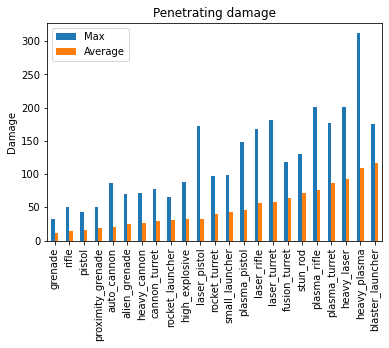

In [9]:
ax = average_damage.plot.bar(title="Penetrating damage", legend=False)
ax.legend(["Max", "Average"])
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

### Base vs Penetrating Damage

In [10]:
average_damage_mean = weapon_data[["weapon", "turn_damage_expected"]]
average_damage_mean = average_damage_mean.groupby("weapon").mean()

In [11]:
average_penetrating_damage_mean = weapon_data_aliens[["weapon", "turn_penetrating_damage_expected"]]
average_penetrating_damage_mean = average_penetrating_damage_mean.groupby("weapon").mean()

In [12]:
average_damage = average_damage_mean.merge(average_penetrating_damage_mean, on="weapon")
average_damage = average_damage.sort_values(by=["turn_penetrating_damage_expected"])

Text(0, 0.5, 'Damage')

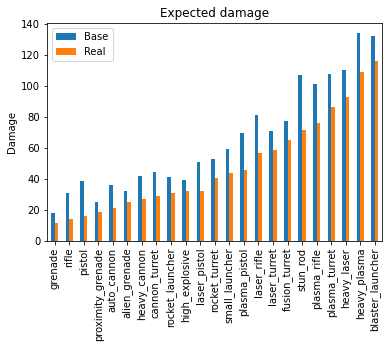

In [13]:
ax = average_damage.plot.bar(title="Expected damage", legend=False)
ax.legend(["Base", "Real"])
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

In [14]:
average_damage_mean = weapon_data[["weapon", "turn_damage_max"]]
average_damage_mean = average_damage_mean.groupby("weapon").mean()

In [15]:
average_penetrating_damage_mean = weapon_data_aliens[["weapon", "turn_penetrating_damage_max"]]
average_penetrating_damage_mean = average_penetrating_damage_mean.groupby("weapon").mean()

In [16]:
average_damage = average_damage_mean.merge(average_penetrating_damage_mean, on="weapon")
average_damage = average_damage.sort_values(by=["turn_penetrating_damage_max"])

Text(0, 0.5, 'Damage')

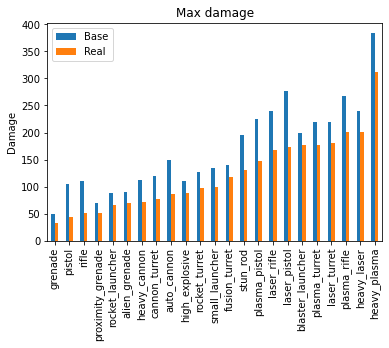

In [17]:
ax = average_damage.plot.bar(title="Max damage", legend=False)
ax.legend(["Base", "Real"])
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

## Ammo

In [18]:
weapon_ammo = weapon_data[["weapon", "capacity"]]
weapon_ammo = weapon_ammo.rename(columns={"capacity": "ammo"})
weapon_ammo = weapon_ammo.groupby("weapon").max()
weapon_ammo = weapon_ammo.sort_values(by=["ammo"])

# Remove weapons with unlimited ammo
weapon_ammo = weapon_ammo[weapon_ammo["ammo"] < 255]

weapon_ammo

,ammo
weapon,
alien_grenade,1.0
rocket_launcher,1.0
proximity_grenade,1.0
high_explosive,1.0
grenade,1.0
small_launcher,1.0
blaster_launcher,1.0
heavy_cannon,6.0
rocket_turret,8.0


Text(0, 0.5, 'Shots')

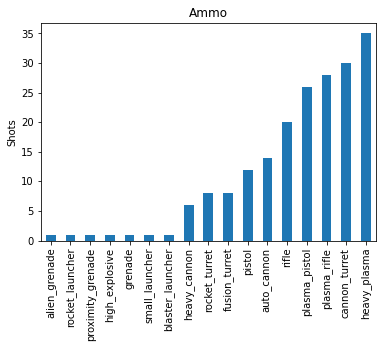

In [19]:
ax = weapon_ammo.plot.bar(title="Ammo", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Shots")

## Damage Per Clip

In [20]:
damage_per_clip = weapon_data[["weapon", "clip_damage"]]
damage_per_clip = damage_per_clip.groupby("weapon").max()
damage_per_clip = damage_per_clip.sort_values(by=["clip_damage"])
damage_per_clip = damage_per_clip.dropna()

In [21]:
penetrating_damage_per_clip = weapon_data_aliens[["weapon", "clip_penetrating_damage"]]
penetrating_damage_per_clip = penetrating_damage_per_clip.groupby("weapon").max()
penetrating_damage_per_clip = penetrating_damage_per_clip.sort_values(by=["clip_penetrating_damage"])
penetrating_damage_per_clip = penetrating_damage_per_clip.dropna()

In [22]:
# Remove weapons with unlimited ammo
damage_per_clip = damage_per_clip.merge(penetrating_damage_per_clip, on="weapon")
damage_per_clip = damage_per_clip[damage_per_clip["clip_damage"] < 10000]

damage_per_clip

,clip_damage,clip_penetrating_damage
weapon,,
grenade,50.0,46.320312
proximity_grenade,70.0,66.300223
alien_grenade,90.0,86.289062
small_launcher,90.0,86.289062
rocket_launcher,100.0,130.864379
high_explosive,110.0,106.281960
blaster_launcher,200.0,220.616346
pistol,312.0,268.622596
heavy_cannon,360.0,481.779412


Text(0, 0.5, 'Damage')

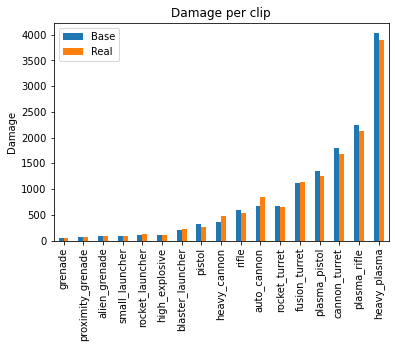

In [23]:
ax = damage_per_clip.plot.bar(title="Damage per clip", legend=False)
ax.legend(["Base", "Real"])
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Damage")

## Time Units

How much does it cost each use of a weapon? Cost is measured in Time Units.

In [24]:
time_units_max = weapon_data[["weapon", "time_units"]]
time_units_max = time_units_max.groupby("weapon").max()

In [25]:
time_units_average = weapon_data[["weapon", "time_units"]]
time_units_average = time_units_average.groupby("weapon").mean()

In [26]:
time_units = time_units_max.merge(time_units_average, on="weapon")
time_units = time_units.rename(columns={"time_units_x": "time_units_max", "time_units_y": "time_units_avg"})
time_units = time_units.sort_values(by=["time_units_avg"])
time_units

,time_units_max,time_units_avg
weapon,,
pistol,30,24.000000
stun_rod,30,30.000000
laser_pistol,55,33.333333
laser_rifle,50,36.333333
plasma_pistol,60,40.000000
heavy_plasma,60,41.666667
plasma_rifle,60,42.000000
plasma_turret,60,45.000000
heavy_laser,60,46.500000


Text(0, 0.5, 'TUs')

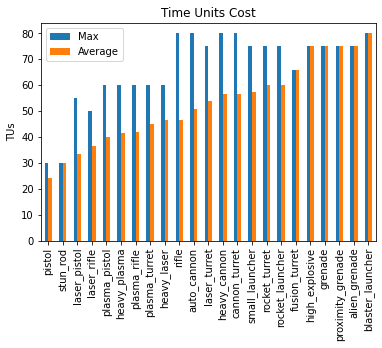

In [27]:
ax = time_units.plot.bar(title="Time Units Cost")
ax.legend(["Max", "Average"])
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("TUs")

## Shots Per Turn

Supposing all the attacks are done on auto, or the highest rate of fire setting.

In [28]:
shots_per_turn_max = weapon_data[["weapon", "turn_max_shots"]]
shots_per_turn_max = shots_per_turn_max.groupby("weapon").max()

In [29]:
shots_per_turn_average = weapon_data[["weapon", "turn_max_shots"]]
shots_per_turn_average = shots_per_turn_average.groupby("weapon").mean()
shots_per_turn_average["turn_max_shots"] = shots_per_turn_average.apply(lambda x: int(x["turn_max_shots"]), axis=1)

In [30]:
shots_per_turn = shots_per_turn_max.merge(shots_per_turn_average, on="weapon")
shots_per_turn = shots_per_turn.rename(columns={"turn_max_shots_x": "turn_shots_max", "turn_max_shots_y": "turn_shots_avg"})
shots_per_turn = shots_per_turn.sort_values(by=["turn_shots_avg"])
shots_per_turn

,turn_shots_max,turn_shots_avg
weapon,,
alien_grenade,1,1
rocket_turret,2,1
blaster_launcher,1,1
fusion_turret,1,1
grenade,1,1
rocket_launcher,1,1
high_explosive,1,1
small_launcher,2,1
proximity_grenade,1,1


Text(0, 0.5, 'Shots')

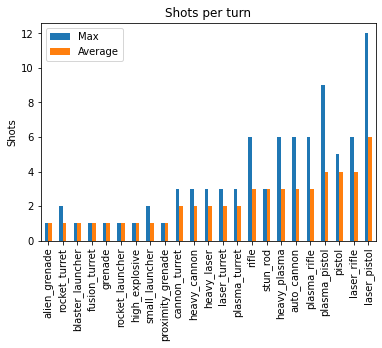

In [31]:
ax = shots_per_turn.plot.bar(title="Shots per turn")
ax.legend(["Max", "Average"])
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Shots")

## Turns of Sustained Fire

Weapons with unlimited ammo are not taken into account.

In [32]:
turns_sustained_fire_max = weapon_data[["weapon", "turns_to_reload"]]
turns_sustained_fire_max = turns_sustained_fire_max.groupby("weapon").max()

# Remove weapons with unlimited ammo
turns_sustained_fire_max = turns_sustained_fire_max[turns_sustained_fire_max["turns_to_reload"] < 70]

In [33]:
turns_sustained_fire_average = weapon_data[["weapon", "turns_to_reload"]]
turns_sustained_fire_average = turns_sustained_fire_average.groupby("weapon").mean()

# Remove weapons with unlimited ammo
turns_sustained_fire_average = turns_sustained_fire_average[turns_sustained_fire_average["turns_to_reload"] < 70]

In [34]:
turns_sustained_fire = turns_sustained_fire_max.merge(turns_sustained_fire_average, on="weapon")
turns_sustained_fire = turns_sustained_fire.rename(columns={"turns_to_reload_x": "turns_sustained_fire_max", "turns_to_reload_y": "turns_sustained_fire_avg"})
turns_sustained_fire = turns_sustained_fire.sort_values(by=["turns_sustained_fire_avg"])
turns_sustained_fire

,turns_sustained_fire_max,turns_sustained_fire_avg
weapon,,
stun_rod,0.0,0.000000
small_launcher,1.0,0.750000
rocket_launcher,1.0,1.000000
proximity_grenade,1.0,1.000000
grenade,1.0,1.000000
alien_grenade,1.0,1.000000
blaster_launcher,1.0,1.000000
high_explosive,1.0,1.000000
pistol,4.0,3.200000


Text(0, 0.5, 'Turns')

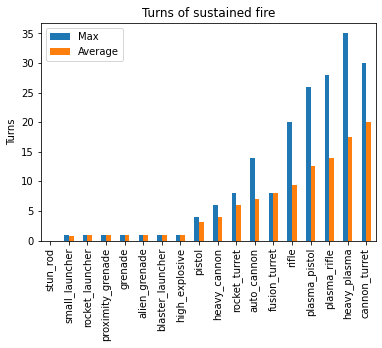

In [35]:
ax = turns_sustained_fire.plot.bar(title="Turns of sustained fire")
ax.legend(["Max", "Average"])
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Turns")

## Damage Per Time Unit

### Base Damage Per Time Unit

In [36]:
damage_per_tu_max = weapon_data[["weapon", "damage_per_time_unit"]]
damage_per_tu_max = damage_per_tu_max.groupby("weapon").max()

In [37]:
damage_per_tu_average = weapon_data[["weapon", "damage_per_time_unit"]]
damage_per_tu_average = damage_per_tu_average.groupby("weapon").mean()

In [38]:
damage_per_tu = damage_per_tu_max.merge(damage_per_tu_average, on="weapon")
damage_per_tu = damage_per_tu.rename(columns={"damage_per_time_unit_x": "damage_per_time_unit_max", "damage_per_time_unit_y": "damage_per_time_unit_avg"})
damage_per_tu = damage_per_tu.sort_values(by=["damage_per_time_unit_avg"])

Text(0, 0.5, 'Ratio')

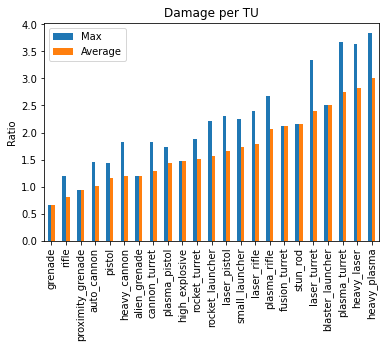

In [39]:
ax = damage_per_tu.plot.bar(title="Damage per TU")
ax.legend(["Max", "Average"])
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Ratio")

### Penetrating Damage Per Time Unit

In [40]:
damage_per_tu_max = weapon_data_aliens[["weapon", "penetrating_damage_per_time_unit"]]
damage_per_tu_max = damage_per_tu_max.groupby("weapon").max()

In [41]:
damage_per_tu_average = weapon_data_aliens[["weapon", "penetrating_damage_per_time_unit"]]
damage_per_tu_average = damage_per_tu_average.groupby("weapon").mean()

In [42]:
damage_per_tu = damage_per_tu_max.merge(damage_per_tu_average, on="weapon")
damage_per_tu = damage_per_tu.rename(columns={"penetrating_damage_per_time_unit_x": "damage_per_time_unit_max", "penetrating_damage_per_time_unit_y": "damage_per_time_unit_avg"})
damage_per_tu = damage_per_tu.sort_values(by=["damage_per_time_unit_avg"])

Text(0, 0.5, 'Ratio')

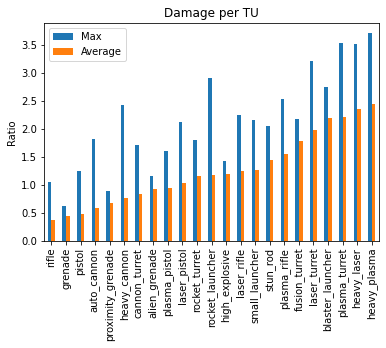

In [43]:
ax = damage_per_tu.plot.bar(title="Damage per TU")
ax.legend(["Max", "Average"])
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Ratio")

## Hits to Kill

In [44]:
hits_to_kill_average = weapon_data_aliens[["weapon", "hits_to_kill"]]
hits_to_kill_average = hits_to_kill_average[hits_to_kill_average["hits_to_kill"] < 200]
hits_to_kill_average = hits_to_kill_average.groupby(["weapon"]).mean()
hits_to_kill_average["hits_to_kill"] = hits_to_kill_average.apply(lambda x: math.ceil(x["hits_to_kill"]), axis=1)
hits_to_kill_average = hits_to_kill_average.sort_values(by=["hits_to_kill"])

Text(0, 0.5, 'Hits')

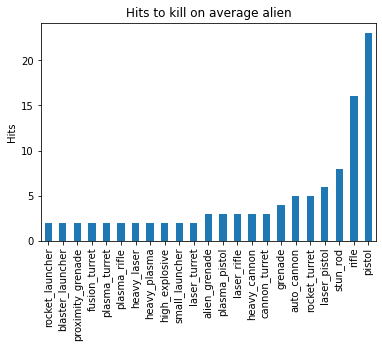

In [45]:
ax = hits_to_kill_average.plot.bar(title="Hits to kill on average alien", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Hits")

### Expected Kills in a Turn

In [46]:
expected_kills = weapon_data_aliens[["weapon", "turn_expected_kills"]]
expected_kills = expected_kills.groupby(["weapon"]).mean()
expected_kills["turn_expected_kills"] = expected_kills.apply(lambda x: math.ceil(x["turn_expected_kills"]), axis=1)
expected_kills = expected_kills.sort_values(by=["turn_expected_kills"])

Text(0, 0.5, 'Kills')

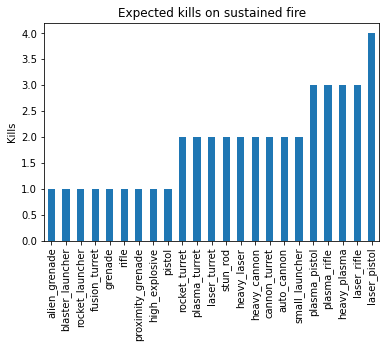

In [47]:
ax = expected_kills.plot.bar(title="Expected kills on sustained fire", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Kills")